# Описание проекта
«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент нужно понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
## Описание тарифов
### Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
### Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

### Разделы исследования данных

* [Открываем файл с данными и изучаем общую информацию](#chapter1)
* [Подготавливаем данные](#chapter2)
* [Анализируем данные](#chapter3)
* [Проверяем гипотезы](#chapter4)
    * [Гипотеза 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается](#section_4_1)
    * [Гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#section_4_2)
* [Общий вывод](#chapter5)

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
calls = pd.read_csv('/datasets/calls.csv')

In [5]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [8]:
users.duplicated().value_counts()

False    500
dtype: int64

В нашей подборке действительно 500 пользователей, из них 38 - меняли тариф в 2018 г.
Давайте просмотрим файл с тарифами - *tariffs*

In [9]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Да, все как в описании, только трафик указан в Мегабайтах *(Мб)*, а тарифах в Гигабайтах *(Гб)*.

1 Гб = 1024 Мб.

15 360 Мб это как раз *15 Гб*, 
а 30 720 Мб - *30 Гб*.  

Все сходится.

Просмотрим информацию о файле с сообщениями

In [11]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [13]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [14]:
messages.duplicated().value_counts()

False    123036
dtype: int64

Мы знаем какой пользователь, сколько и когда написал смс-сообщение, Каждому новому сообщению присваивается свой *id* и порядковый номер сообщения для отдельно взятого пользователя. Так, отслеживается выполнение тарифа с ограничением числа сообщений. Можем выяснить топ-5 пользователей, которые любят отправлять короткие сообщения.

In [15]:
messages.groupby('user_id')['id'].count()

user_id
1000     496
1002      70
1003     380
1004    1192
1005     552
        ... 
1495     340
1496     468
1497      51
1498     168
1499     184
Name: id, Length: 426, dtype: int64

In [16]:
messages.groupby('user_id')['id'].describe().sort_values(by='count', ascending=False).head()

,count,unique,top,freq
user_id,,,,
1277,1463,1463,1277_1366,1
1089,1408,1408,1089_278,1
1231,1384,1384,1231_99,1
1385,1380,1380,1385_481,1
1356,1224,1224,1356_165,1


In [17]:
users[users['user_id']==1277]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
277,1277,30,NaN,Новосибирск,Валерия,Андреенко,2018-02-19,ultra


1463 сообщения за 2018 год, это почти по 4.6 сообщения в день в течение года. Хотя тариф, конечно, позволяет отправлять большее число сообщений.

Изучим файл с информацией о звонках и соберем топ-5 любителей поговорить по телефону.

In [18]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [19]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [20]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [21]:
calls.duplicated().value_counts()

False    202607
dtype: int64

In [22]:
calls.groupby('user_id')['duration'].sum().sort_values(ascending=False).head()

user_id
1377    12258.20
1168    11624.25
1375    10757.17
1453     9711.35
1196     8204.08
Name: duration, dtype: float64

In [23]:
users[users['user_id']==1377]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
377,1377,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra


Пользователь *1377* зарегистрировался в феврале 2018 и активно пользуется возможностями тарифа в части минут разговора.

In [24]:
calls.groupby('user_id')['duration'].min().count()

492

У нас 492 случая, со звонками в 0.0 минут. Так как "Мегалайн" округляет звонки только с *1 секунды*, то такие звонки будем считать пропущенными.

In [25]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [26]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [27]:
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [28]:
internet.duplicated().value_counts()

False    149396
dtype: int64

Присутствует столбец *Unnamed: 0*, возможно, он технический и нумерует строку.

In [29]:
internet.groupby('user_id')['mb_used'].sum().sort_values(ascending=False).head(10)

user_id
1385    376397.38
1240    376237.47
1180    348211.20
1185    343533.71
1330    336373.28
1292    335189.57
1168    333028.41
1126    309616.68
1381    300804.48
1148    297569.98
Name: mb_used, dtype: float64

Обратим внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута

### Вывод

Нам предоставили информацию в нескольких файлах. Файлы не содержат пропущенных значений и дубликатов.
В таблице звонков присутствуют нулевые значения, которые в дальнейшем будут интерпритироваться как пропущенные вызовы, это нужно будет иметь ввиду, когда будем считать общее количество звонков по пользователям для статистики.

Информация о расходе трафика приведена в Мегабайтах, а в тарифе указан порог в Гигабайтах. Такое описание тарифа удобно для пользователя, а нам предстоит такие значения дополнительно обработать.

### Подготавливаем данные <a class="anchor" id="chapter2"></a>

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Дата подключения тарифа и дата смены тарифа сейчас в формате *object*, для дальнейшей работы с этим столбцами переведем их формат даты *datetime64*.

In [31]:
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y/%m/%d')

In [32]:
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y/%m/%d')

In [33]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Так как данные анализируются только за один 2018 год, создадим столбец с месяцем и днем регистрации.

In [34]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')

In [35]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-01
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-01
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-01


Сформируем таблицу, где на каждому пользователю будет присвоен каждый месяц

In [36]:
min_month = users['reg_date'].values.astype('datetime64[M]').min()

In [37]:
max_month = users['reg_date'].values.astype('datetime64[M]').max()

In [38]:
(min_month, max_month)

(numpy.datetime64('2018-01'), numpy.datetime64('2018-12'))

In [39]:
pd.date_range(min_month,max_month,freq='MS')

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

В нашей выборке только те пользователи, которые были зарегистрированы в 2018 г.

In [40]:
u_month = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))

In [41]:
u_month

,0
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [42]:
u_month.columns = ['month']

In [43]:
len(users)*len(u_month)

6000

Все верно - 500 пользователей по 12 месяцев = 6000 строк

In [44]:
u_month['key'] = 1
users['key'] = 1

In [45]:
df_users = u_month.merge(users,on='key')

In [46]:
df_users.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-01
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-01
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-01


In [47]:
len(df_users)

6000

Отлично, сошлось. Теперь избавимся от лишних значений-зачем хранить информацию о месяце, если пользователь зарегистрировался позже?

In [48]:
len(df_users[df_users['month']>=df_users['reg_month']])

3259

In [49]:
df_users = df_users[df_users['month']>=df_users['reg_month']]

Теперь мы сможем посмотреть информацию по кажому пользователю помесячно

In [50]:
df_users[df_users['user_id']==1000]

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
2000,2018-05-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
2500,2018-06-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
3000,2018-07-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
3500,2018-08-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
4000,2018-09-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
4500,2018-10-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
5000,2018-11-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
5500,2018-12-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01


Пользователь из Краснодара, мужчина 52-ти лет зарегистрировался в мае и выбрал тариф *ultra*.

In [54]:
#def tariff(row):
#    reg_date = row['reg_date']
#    churn_date = row['churn_date']
#    tariff = row['tariff']
#    month = row['month']
#    
#    if churn_date <= month:
#        return tariff
#    else:
#        if 'ultra' in tariff:
#            return 'smart'
#        if 'smart' in tariff:
#            return 'ultra'
#    
#df_users['tariff'] = df_users.apply(tariff, axis = 1)

In [55]:
#df_users[df_users['user_id']==1370]

Перейдем к следующим талицам с сообщениями, звонками и трафиком интернета

In [56]:
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y/%m/%d')

In [57]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Проделаем тот же путь с сортировкой сообщений помесячно

In [58]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

In [59]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [60]:
grouped_messages = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index().rename({'id':'messages'}, axis=1)

In [61]:
grouped_messages[(grouped_messages['user_id']==1000)]

,user_id,month,messages
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
5,1000,2018-10-01,73
6,1000,2018-11-01,58
7,1000,2018-12-01,70


Пользователь с *id 1000* отправляет сообщения в рамках своего тарифа

Проделаем то же самое с сортировкой звонков помесячно

In [62]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y/%m/%d')

In [63]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [64]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

In [65]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-01


"Мегалайн" для своих начислений 0,01 секунду разговора тарифицирует и принимает как 1 минуту. Поэтому давайте сразу округлим наши минут разговора до целых в большую сторону.

In [66]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int32')

In [67]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,2018-07-01
1,1000_1,2018-08-17,0,1000,2018-08-01
2,1000_2,2018-06-11,3,1000,2018-06-01
3,1000_3,2018-09-21,14,1000,2018-09-01
4,1000_4,2018-12-15,6,1000,2018-12-01


In [68]:
grouped_calls = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index().rename({'id':'calls', 'duration':'duration'}, axis=1)

In [69]:
grouped_calls[grouped_calls['user_id']==1000]

,user_id,month,duration,calls
0,1000,2018-05-01,159,22
1,1000,2018-06-01,172,43
2,1000,2018-07-01,340,47
3,1000,2018-08-01,408,52
4,1000,2018-09-01,466,58
5,1000,2018-10-01,350,57
6,1000,2018-11-01,338,43
7,1000,2018-12-01,333,46


Наш пользователь с *id 1000* разговаривает и тратит минуты в рамках своего тарифа, больше всего потратил минут в сентябре

In [70]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y/%m/%d')

In [71]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [72]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

In [73]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,4,1000_4,302.56,2018-09-24,1000,2018-09-01


In [74]:
grouped_internet = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index().rename({'mb_used':'mb_used'}, axis=1)

In [75]:
grouped_internet[grouped_internet['user_id']==1000]

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91
5,1000,2018-10-01,14702.49
6,1000,2018-11-01,14756.47
7,1000,2018-12-01,9817.61


Наш пользователь *id 1000* активно пользуется интернетом, но использует возможности своего тарифа по части трафика - всего наполовину

Соберем одну таблицу воедино, она будет включать информацию о самом пользователе, дате регистрации, текущем тарифе, а также о совершенных звонках и потраченных минут, количестве отправленных сообщений, информацию об использовании трафика.

In [76]:
grouped_messages['messages'].sum()

123036

In [77]:
df = df_users.merge(grouped_messages, on=['user_id', 'month'], how='outer')

In [78]:
df = df[['month', 'user_id', 'age', 'city', 'reg_date', 'tariff', 'reg_month', 'messages']]

In [79]:
df.head()

,month,user_id,age,city,reg_date,tariff,reg_month,messages
0,2018-01-01,1005,67,Набережные Челны,2018-01-25,smart,2018-01-01,7.0
1,2018-01-01,1032,31,Ульяновск,2018-01-04,smart,2018-01-01,38.0
2,2018-01-01,1045,48,Улан-Удэ,2018-01-30,smart,2018-01-01,5.0
3,2018-01-01,1055,39,Казань,2018-01-02,smart,2018-01-01,30.0
4,2018-01-01,1071,20,Омск,2018-01-09,smart,2018-01-01,16.0


In [80]:
df['messages'].sum()

123036.0

Количество сообщений после объединения сошлось с суммой сообщений в таблице *grouped_messages*. Все сделали верно)

In [81]:
grouped_calls['duration'].sum()

1450301

In [82]:
grouped_calls['calls'].sum()

202607

In [83]:
df = df.merge(grouped_calls, on=['user_id', 'month'], how='outer')

In [84]:
df.head()

,month,user_id,age,city,reg_date,tariff,reg_month,messages,duration,calls
0,2018-01-01,1005,67,Набережные Челны,2018-01-25,smart,2018-01-01,7.0,95.0,15.0
1,2018-01-01,1032,31,Ульяновск,2018-01-04,smart,2018-01-01,38.0,380.0,61.0
2,2018-01-01,1045,48,Улан-Удэ,2018-01-30,smart,2018-01-01,5.0,9.0,1.0
3,2018-01-01,1055,39,Казань,2018-01-02,smart,2018-01-01,30.0,551.0,64.0
4,2018-01-01,1071,20,Омск,2018-01-09,smart,2018-01-01,16.0,194.0,24.0


In [85]:
df['duration'].sum()

1450301.0

In [86]:
df['calls'].sum()

202607.0

Количество звонков и затраченные минуты после объединения сошлись с данными таблицы *grouped_calls*. Все сделали верно)

In [87]:
grouped_internet['mb_used'].sum()

55305267.730000004

In [88]:
df = df.merge(grouped_internet, on=['user_id', 'month'], how='outer')

In [89]:
df.head()

,month,user_id,age,city,reg_date,tariff,reg_month,messages,duration,calls,mb_used
0,2018-01-01,1005,67,Набережные Челны,2018-01-25,smart,2018-01-01,7.0,95.0,15.0,2727.97
1,2018-01-01,1032,31,Ульяновск,2018-01-04,smart,2018-01-01,38.0,380.0,61.0,24127.69
2,2018-01-01,1045,48,Улан-Удэ,2018-01-30,smart,2018-01-01,5.0,9.0,1.0,2346.71
3,2018-01-01,1055,39,Казань,2018-01-02,smart,2018-01-01,30.0,551.0,64.0,17090.88
4,2018-01-01,1071,20,Омск,2018-01-09,smart,2018-01-01,16.0,194.0,24.0,15604.34


In [90]:
df['mb_used'].sum()

55305267.730000004

Тоже все сошлось с данными таблицы *grouped_internet* общего трафика. Все сделали верно)

Добавим к нашим данным информацию о об ограничениях наших тарифов.

In [91]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переименуем столбец *tariff_name* на *tariff*, так мы сможем по нему соединить данные

In [92]:
tariffs=tariffs.rename({'tariff_name':'tariff'}, axis=1)

In [93]:
df = df.merge(tariffs, on=['tariff'], how='outer')

In [94]:
df.head()

,month,user_id,age,city,reg_date,tariff,reg_month,messages,duration,calls,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,2018-01-01,1005,67,Набережные Челны,2018-01-25,smart,2018-01-01,7.0,95.0,15.0,2727.97,50,15360,500,550,200,3,3
1,2018-01-01,1032,31,Ульяновск,2018-01-04,smart,2018-01-01,38.0,380.0,61.0,24127.69,50,15360,500,550,200,3,3
2,2018-01-01,1045,48,Улан-Удэ,2018-01-30,smart,2018-01-01,5.0,9.0,1.0,2346.71,50,15360,500,550,200,3,3
3,2018-01-01,1055,39,Казань,2018-01-02,smart,2018-01-01,30.0,551.0,64.0,17090.88,50,15360,500,550,200,3,3
4,2018-01-01,1071,20,Омск,2018-01-09,smart,2018-01-01,16.0,194.0,24.0,15604.34,50,15360,500,550,200,3,3


Добавим в нашу таблицу данные расчета перерасхода тарифа.
Если результат отрицательный, то все в рамках тарифа, если положительный - то будем учитывать такую разницу по ценам соответствующего тарифа.

In [95]:
df['minutes_overrun']  = df['duration'] - df['minutes_included']
df['messages_overrun'] = df['messages'] - df['messages_included']
df['mb_overrun']  = df['mb_used'] - df['mb_per_month_included'] 

In [96]:
def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_mb = 0
    rub_monthly_fee = row['rub_monthly_fee']
    
    if row['minutes_overrun'] > 0:
        revenue_by_min = row['minutes_overrun'] * row['rub_per_minute']
    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message']
    if row['mb_overrun'] > 0:
        revenue_mb = (row['mb_overrun'] / 1024) * row['rub_per_gb']
    return revenue_by_min + revenue_by_messages + revenue_mb + rub_monthly_fee
df['revenue'] = df.apply(get_revenue, axis = 1)

In [97]:
df.head(10)

,month,user_id,age,city,reg_date,tariff,reg_month,messages,duration,calls,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,mb_overrun,revenue
0,2018-01-01,1005,67,Набережные Челны,2018-01-25,smart,2018-01-01,7.0,95.0,15.0,...,15360,500,550,200,3,3,-405.0,-43.0,-12632.03,550.000000
1,2018-01-01,1032,31,Ульяновск,2018-01-04,smart,2018-01-01,38.0,380.0,61.0,...,15360,500,550,200,3,3,-120.0,-12.0,8767.69,2262.439453
2,2018-01-01,1045,48,Улан-Удэ,2018-01-30,smart,2018-01-01,5.0,9.0,1.0,...,15360,500,550,200,3,3,-491.0,-45.0,-13013.29,550.000000
3,2018-01-01,1055,39,Казань,2018-01-02,smart,2018-01-01,30.0,551.0,64.0,...,15360,500,550,200,3,3,51.0,-20.0,1730.88,1041.062500
4,2018-01-01,1071,20,Омск,2018-01-09,smart,2018-01-01,16.0,194.0,24.0,...,15360,500,550,200,3,3,-306.0,-34.0,244.34,597.722656
5,2018-01-01,1113,52,Чита,2018-01-24,smart,2018-01-01,14.0,110.0,18.0,...,15360,500,550,200,3,3,-390.0,-36.0,-14593.78,550.000000
6,2018-01-01,1134,65,Красноярск,2018-01-16,smart,2018-01-01,32.0,332.0,42.0,...,15360,500,550,200,3,3,-168.0,-18.0,-5159.99,550.000000
7,2018-01-01,1135,64,Архангельск,2018-01-29,smart,2018-01-01,1.0,90.0,9.0,...,15360,500,550,200,3,3,-410.0,-49.0,-13759.72,550.000000
8,2018-01-01,1155,71,Ставрополь,2018-01-02,smart,2018-01-01,48.0,337.0,44.0,...,15360,500,550,200,3,3,-163.0,-2.0,4765.87,1480.833984
9,2018-01-01,1176,37,Волгоград,2018-01-20,smart,2018-01-01,20.0,187.0,25.0,...,15360,500,550,200,3,3,-313.0,-30.0,-8505.08,550.000000


Теперь у нас собраны полные данные, они содержат помесячную информацию о каждом пользователе, о выбранном тарифе и условиях тарифа, по каждому пользователю видим информацию о совокупным за месяц количестве сообщений, минут разговоров и использованном трафике.

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3259 entries, 0 to 3258
Data columns (total 22 columns):
month                    3259 non-null datetime64[ns]
user_id                  3259 non-null int64
age                      3259 non-null int64
city                     3259 non-null object
reg_date                 3259 non-null datetime64[ns]
tariff                   3259 non-null object
reg_month                3259 non-null datetime64[ns]
messages                 2717 non-null float64
duration                 3174 non-null float64
calls                    3174 non-null float64
mb_used                  3203 non-null float64
messages_included        3259 non-null int64
mb_per_month_included    3259 non-null int64
minutes_included         3259 non-null int64
rub_monthly_fee          3259 non-null int64
rub_per_gb               3259 non-null int64
rub_per_message          3259 non-null int64
rub_per_minute           3259 non-null int64
minutes_overrun          3174 non-null float64

In [99]:
df.duplicated().value_counts()

False    3259
dtype: int64

### Вывод

Мы понимаем какие данные пропущены, ведь мы их сами собирали потаблично. 

У нас получилась таблица на 3259 строк и 27 колонок, размер меньше 1 мегабайта, без дубликатов в данных.

### Анализируем данные <a class="anchor" id="chapter3"></a>

Сгруппируем данные по выручке, в зависимости от выбранного тарифного плана. И для дальнейшего анализа, переведем наш трафик из мегабайтов в гигабайты.

In [100]:
df['gb_used'] = (df['mb_used'] / 1024).round(2)
df['gb_overrun'] = (df['mb_overrun'] / 1024).round(2)

In [101]:
df['user'] = 1

In [102]:
df[df['tariff']=='smart'].groupby('month')[['revenue','user','messages','duration','gb_used']].agg('sum')

,revenue,user,messages,duration,gb_used
month,,,,,
2018-01-01,23856.982422,34,620.0,6931.0,282.67
2018-02-01,46590.041016,58,1397.0,17324.0,656.86
2018-03-01,85916.808594,77,2453.0,30034.0,1135.77
2018-04-01,103093.320312,112,3443.0,41119.0,1472.43
2018-05-01,161343.541016,141,4762.0,54618.0,2176.29
2018-06-01,188088.599609,164,5478.0,64885.0,2529.64
2018-07-01,234224.917969,201,6784.0,82079.0,3090.20
2018-08-01,295012.304688,235,7905.0,99045.0,3812.10
2018-09-01,311581.029297,261,8746.0,111439.0,4139.62


In [103]:
df[df['tariff']=='ultra'].groupby('month')[['revenue','user','messages','duration','gb_used']].agg('sum')

,revenue,user,messages,duration,gb_used
month,,,,,
2018-01-01,17550.000000,9,304.0,3853.0,115.48
2018-02-01,47343.958008,24,527.0,7131.0,276.02
2018-03-01,74130.880371,37,1195.0,18117.0,633.62
2018-04-01,109725.912598,55,1736.0,25191.0,903.84
2018-05-01,137649.963867,67,2536.0,34192.0,1266.92
2018-06-01,170649.014648,84,3505.0,40295.0,1552.50
2018-07-01,191806.013672,91,4536.0,49667.0,1821.41
2018-08-01,221531.037598,107,5183.0,54653.0,2045.49
2018-09-01,233464.627441,116,6013.0,62036.0,2156.71


Как мы видим, пользователей на *ultra* больше, чем на *smart*, они больше отправляют смс, у них длиньше разговоры и дольше длится интернет-серфинг.
Для дальнейшего детального анализа по каждому пользователю, создадим таблицу, где ежемесячные данные будут располагаться по столбцам, а строки - наши пользователи сети.

Отберем пользователей тарифа *smart* и рассчитаем дисперсию выборки по каждому месяцу.

In [104]:
smart = df.query('tariff =="smart"')

In [105]:
smart.mean(axis=0)

user_id                   1246.479361
age                         46.556147
messages                    38.716441
duration                   419.062978
calls                       58.621233
mb_used                  16215.661849
messages_included           50.000000
mb_per_month_included    15360.000000
minutes_included           500.000000
rub_monthly_fee            550.000000
rub_per_gb                 200.000000
rub_per_message              3.000000
rub_per_minute               3.000000
minutes_overrun            -80.937022
messages_overrun           -11.283559
mb_overrun                 855.661849
revenue                   1223.193958
gb_used                     15.835714
gb_overrun                   0.835714
user                         1.000000
dtype: float64

In [106]:
smart_messages = smart.pivot(index='user_id', columns='month', values='messages')

In [107]:
smart_messages.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,31.00,50.00,69.00,96.00,122.00,142.00,174.00,204.00,223.00,254.00,270.00,287.00
mean,20.00,27.94,35.55,35.86,39.03,38.58,38.99,38.75,39.22,39.08,39.88,42.26
std,15.88,20.99,25.88,22.76,25.27,27.05,26.82,27.70,26.50,27.14,26.67,28.85
min,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,7.50,12.25,14.00,18.75,18.50,18.25,19.00,16.75,18.00,16.00,18.00,19.00
50%,16.00,22.50,29.00,32.50,37.00,33.00,35.00,33.50,34.00,35.00,34.00,38.00
75%,28.50,42.75,55.00,49.25,55.00,52.00,56.00,56.00,54.50,55.75,57.75,59.00
max,74.00,85.00,110.00,105.00,103.00,134.00,137.00,134.00,136.00,139.00,124.00,143.00


Пользователи тарифа нечасто пользуются отправкой смс-сообщений и тем не менее, в выборке присутствуют пользователи, которые отправляют 140+ сообщений в месяц. Среднее количество в месяц около 40 сообщений.

In [109]:
smart_extra_messages = smart[(smart['messages'] - 50)*3>0]
(smart_extra_messages['messages_overrun'] * 3).sum()

38784.0

In [110]:
smart_extra_messages['user_id'].value_counts().head(10)

1433    12
1472    11
1302    11
1282    11
1425    10
1358    10
1285    10
1158    10
1251    10
1217    10
Name: user_id, dtype: int64

"Мегалайн" в год получает дополнительной прибыли на смс сверх лимита - 38 784 руб.
10-12 смс сверх лимита по 3 рубля - выглядит не так разоряюще.

In [111]:
np.var(smart_messages, ddof=1)

month
2018-01-01    252.133333
2018-02-01    440.465714
2018-03-01    669.780477
2018-04-01    517.865680
2018-05-01    638.775776
2018-06-01    731.635801
2018-07-01    719.352468
2018-08-01    767.213054
2018-09-01    702.505555
2018-10-01    736.503019
2018-11-01    711.361366
2018-12-01    832.447114
dtype: float64

Рассчитаем стандартное отклонение по каждому показателю в нашей выборке. Сделаем расчет отдельно, не через метод describe()

In [112]:
np.std(smart_messages, ddof=1)

month
2018-01-01    15.878707
2018-02-01    20.987275
2018-03-01    25.880117
2018-04-01    22.756662
2018-05-01    25.274014
2018-06-01    27.048767
2018-07-01    26.820747
2018-08-01    27.698611
2018-09-01    26.504821
2018-10-01    27.138589
2018-11-01    26.671359
2018-12-01    28.852160
dtype: float64

Text(0.5, 0, 'Количество сообщений')

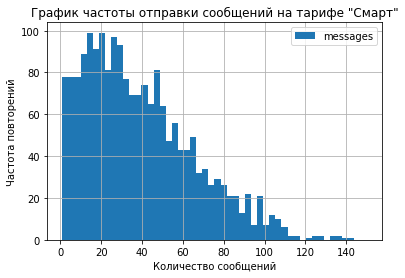

In [113]:
#smart.messages.hist(bins=50, range=(1,150))
ax = smart.plot(y='messages', kind='hist', bins=50, range=(1,150), figsize = (6, 4), grid=True, title='График частоты отправки сообщений на тарифе "Смарт"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Количество сообщений')

Частота наших значений скошена вправо, присутствуют выбросы данных.
Рассчитаем дисперсию, стандартное отклонение и построим гистограмму для звонков по тарифу *smart*

In [114]:
smart_calls = smart.pivot(index='user_id', columns='month', values='duration')

In [115]:
smart_calls.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,34.00,58.00,77.00,112.00,141.00,163.00,201.00,234.00,259.00,293.00,315.00,336.00
mean,203.85,298.69,390.05,367.13,387.36,398.07,408.35,423.27,430.27,427.59,436.65,479.99
std,154.23,190.82,191.89,186.49,186.60,173.09,179.58,184.87,181.52,186.79,176.35,197.82
min,0.00,2.00,13.00,0.00,2.00,7.00,2.00,7.00,23.00,9.00,12.00,15.00
25%,78.25,137.00,234.00,222.00,213.00,275.50,281.00,291.00,298.50,297.00,313.00,340.00
50%,162.50,258.00,409.00,368.50,433.00,401.00,414.00,432.50,436.00,428.00,430.00,471.00
75%,325.25,457.50,530.00,493.50,512.00,523.00,535.00,537.75,550.00,549.00,554.50,600.75
max,551.00,747.00,822.00,785.00,820.00,875.00,839.00,1000.00,843.00,1005.00,954.00,1435.00


In [119]:
len(smart[(smart['duration'] - 500)*3>=1950])

1

In [120]:
smart_extra_duration_change = smart[(smart['duration'] - 500)*3>=1400]
(smart_extra_duration_change['minutes_overrun'] * 3).sum()

12561.0

In [121]:
smart_extra_duration_change['user_id'].value_counts()

1229    1
1261    1
1451    1
1486    1
1319    1
1173    1
1216    1
Name: user_id, dtype: int64

In [122]:
smart_extra_duration = smart[(smart['duration'] - 500)*3>0]
(smart_extra_duration['minutes_overrun'] * 3).sum()

278217.0

Всего "Мегалайн" получает дополнительной прибыли на минутах сверх лимита- 278 217 руб.

In [123]:
np.var(smart_calls, ddof=1)

month
2018-01-01    23787.341355
2018-02-01    36412.287961
2018-03-01    36823.155161
2018-04-01    34778.207127
2018-05-01    34820.061094
2018-06-01    29960.520109
2018-07-01    32250.269602
2018-08-01    34177.270551
2018-09-01    32950.529526
2018-10-01    34889.530319
2018-11-01    31100.611101
2018-12-01    39131.447539
dtype: float64

In [124]:
np.std(smart_calls, ddof=1)

month
2018-01-01    154.231454
2018-02-01    190.820041
2018-03-01    191.893604
2018-04-01    186.489161
2018-05-01    186.601343
2018-06-01    173.091075
2018-07-01    179.583601
2018-08-01    184.870956
2018-09-01    181.522807
2018-10-01    186.787393
2018-11-01    176.353653
2018-12-01    197.816702
dtype: float64

Text(0.5, 0, 'Количество минут')

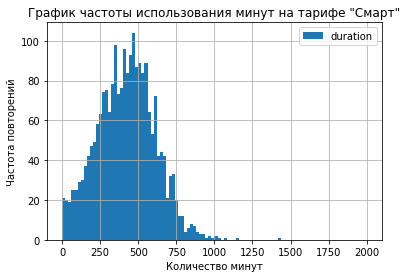

In [125]:
#smart.duration.hist(bins=100, range=(1,2000))
ax = smart.plot(y='duration', kind='hist', bins=100, range=(1,2000), figsize = (6, 4), grid=True, title='График частоты использования минут на тарифе "Смарт"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Количество минут')

In [126]:
smart_gb = smart.pivot(index='user_id', columns='month', values='gb_used')

In [127]:
smart_gb.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,34.00,58.00,77.00,112.00,141.00,164.00,201.00,234.00,260.00,294.00,316.00,337.00
mean,8.31,11.33,14.75,13.15,15.43,15.42,15.37,16.29,15.92,16.36,16.50,17.69
std,6.29,6.10,5.69,5.56,5.84,5.66,5.76,5.37,5.07,5.72,5.21,5.44
min,0.53,0.20,1.95,0.52,0.65,0.47,0.36,2.19,0.36,0.00,0.58,4.41
25%,3.01,7.33,10.93,9.09,12.16,12.06,11.94,13.08,12.52,13.23,13.31,14.33
50%,6.93,12.26,15.30,13.76,15.94,15.70,15.55,16.44,15.66,16.82,16.62,17.30
75%,11.12,14.76,19.75,17.02,19.07,19.20,19.31,19.86,19.72,20.02,19.69,21.02
max,23.56,27.82,24.37,26.40,29.03,33.09,28.77,30.35,30.29,31.97,35.42,37.65


В среднем большинство пользователей платят сверх лимита 15 Гб

In [129]:
len(smart[(smart['gb_used'] - 15)*200>=0])

1306

За интернет переплачивают чаще, чем за смс и звонки. Давайте снова определим тех, кому выгоднее переходить на тариф *ultra*, ну, или тех, кто генерит дополнительную прибыль "Мегалайну":

In [130]:
smart_extra_gb_change = smart[(smart['gb_used'] - 15)*200>=1950]
(smart_extra_gb_change['gb_overrun'] * 200).sum()

262662.0

In [131]:
smart_extra_gb_change['user_id'].value_counts().head(10)

1172    5
1072    4
1014    4
1496    3
1138    3
1157    3
1105    3
1241    3
1420    2
1065    2
Name: user_id, dtype: int64

Вот этим пользователям выше было бы выгоднее пользоваться другим тарифом. С другой стороны, "Мегалайн" может проводить различные акции и розыгрыши с их участием, что бы удержать такого нерассчетливого клиента как можно дольше.
В общей сумме, за 2018 год они принесли "Мегалайну" 262 662 рубля.

In [132]:
np.var(smart_gb, ddof=1)

month
2018-01-01    39.608449
2018-02-01    37.216583
2018-03-01    32.399366
2018-04-01    30.968226
2018-05-01    34.083259
2018-06-01    31.983128
2018-07-01    33.169091
2018-08-01    28.832958
2018-09-01    25.750455
2018-10-01    32.740555
2018-11-01    27.194961
2018-12-01    29.626675
dtype: float64

In [133]:
np.std(smart_gb, ddof=1)

month
2018-01-01    6.293524
2018-02-01    6.100540
2018-03-01    5.692044
2018-04-01    5.564910
2018-05-01    5.838087
2018-06-01    5.655363
2018-07-01    5.759261
2018-08-01    5.369633
2018-09-01    5.074491
2018-10-01    5.721936
2018-11-01    5.214879
2018-12-01    5.443039
dtype: float64

Text(0.5, 0, 'Количество Гб')

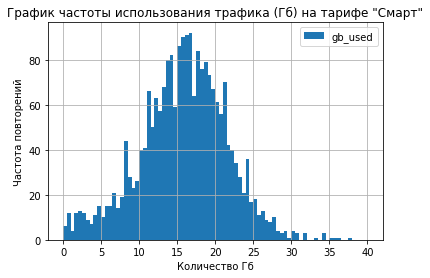

In [134]:
#smart.gb_used.hist(bins=80, range=(0,40))
ax = smart.plot(y='gb_used', kind='hist', bins=80, range=(0,40), figsize = (6, 4), grid=True, title='График частоты использования трафика (Гб) на тарифе "Смарт"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Количество Гб')

Присутствуют выбросы, но гистограмма по трафику больше похожа на нормальное распределение. Средние и медианные значения использования трафика отличаются ненамного.

In [135]:
smart_revenue = smart.pivot(index='user_id', columns='month', values='revenue')

In [136]:
smart_revenue.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,34.00,58.00,77.00,112.00,141.00,164.00,201.00,235.00,261.00,296.00,323.00,351.00
mean,701.68,803.28,1115.80,920.48,1144.28,1146.88,1165.30,1255.37,1193.80,1296.68,1264.33,1464.26
std,418.53,511.56,660.63,524.02,685.27,709.70,703.69,756.11,696.74,809.14,764.57,1010.99
min,550.00,550.00,550.00,550.00,550.00,550.00,550.00,550.00,550.00,550.00,550.00,550.00
25%,550.00,550.00,550.00,550.00,550.00,550.00,553.00,562.00,573.88,550.00,596.72,676.00
50%,550.00,550.00,873.11,587.50,931.75,881.97,909.24,966.89,919.95,1053.68,1081.06,1147.23
75%,550.00,734.50,1556.21,1189.45,1507.44,1508.33,1520.37,1747.90,1665.49,1775.89,1665.57,1954.77
max,2262.44,3396.39,2613.37,2829.68,3368.63,4291.44,3303.99,4259.10,3616.52,4083.32,5563.22,6699.78


В среднем, пользователи тарифа тратят около 1100 рублей на связь, максимально по этому тарифу доплатили 6149 рублtq за перерасход в ноябре 2018 года.

Text(0.5, 0, 'Расходы на связь по тарифу *Smart* (руб.)')

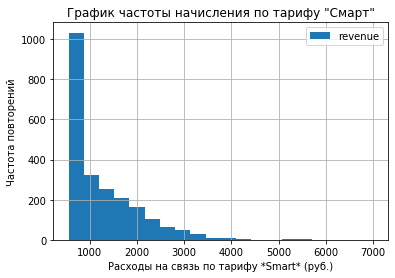

In [138]:
#smart.revenue.hist(bins=20, range=(550,7000))
ax = smart.plot(y='revenue', kind='hist', bins=20, range=(550,7000), figsize = (6, 4), grid=True, title='График частоты начисления по тарифу "Смарт"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Расходы на связь по тарифу *Smart* (руб.)')

In [139]:
ultra = df.query('tariff =="ultra"')

In [140]:
ultra_messages = ultra.pivot(index='user_id', columns='month', values='messages')

In [141]:
ultra_messages.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,7.00,16.00,25.00,39.00,52.00,67.00,73.00,88.00,95.00,103.00,113.00,117.00
mean,43.43,32.94,47.80,44.51,48.77,52.31,62.14,58.90,63.29,69.78,66.16,72.01
std,27.66,26.71,42.74,37.53,39.49,44.00,46.81,44.98,43.67,49.26,47.43,48.61
min,4.00,2.00,1.00,3.00,1.00,3.00,1.00,2.00,1.00,1.00,2.00,1.00
25%,23.00,5.75,20.00,13.50,21.00,21.50,27.00,22.75,27.00,30.00,28.00,37.00
50%,50.00,35.50,27.00,34.00,34.00,39.00,51.00,47.50,56.00,61.00,58.00,61.00
75%,64.50,50.00,68.00,69.00,66.25,73.00,91.00,85.50,89.00,100.50,94.00,99.00
max,75.00,90.00,155.00,143.00,148.00,201.00,211.00,180.00,188.00,223.00,197.00,224.00


Пользователи тарифа *ultra* не так активно используют возможности тарифа, он позволяет отправить до 1000 сообщений в месяц без переплаты. Никто не превысил эту планку. В среднем пользователю хватает отправить около 55 сообщений в месяц.

In [143]:
np.var(ultra_messages, ddof=1)

month
2018-01-01     765.285714
2018-02-01     713.395833
2018-03-01    1826.666667
2018-04-01    1408.256410
2018-05-01    1559.553544
2018-06-01    1935.672999
2018-07-01    2190.730974
2018-08-01    2022.966432
2018-09-01    1906.763270
2018-10-01    2426.606511
2018-11-01    2249.295828
2018-12-01    2362.870616
dtype: float64

In [144]:
np.std(ultra_messages, ddof=1)

month
2018-01-01    27.663798
2018-02-01    26.709471
2018-03-01    42.739521
2018-04-01    37.526743
2018-05-01    39.491183
2018-06-01    43.996284
2018-07-01    46.805245
2018-08-01    44.977399
2018-09-01    43.666501
2018-10-01    49.260598
2018-11-01    47.426742
2018-12-01    48.609368
dtype: float64

Text(0.5, 0, 'Количество сообщений')

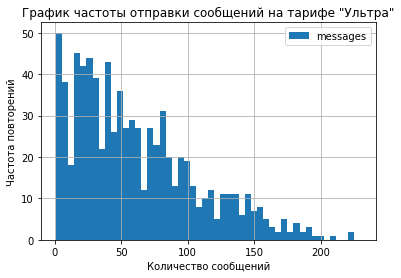

In [145]:
#ultra.messages.hist(bins=50, range=(1,230))
ax = ultra.plot(y='messages', kind='hist', bins=50, range=(1,230), figsize = (6, 4), grid=True, title='График частоты отправки сообщений на тарифе "Ультра"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Количество сообщений')

Частота наших значений скошена вправо, присутствуют выбросы данных.

In [146]:
ultra_calls = ultra.pivot(index='user_id', columns='month', values='duration')

In [147]:
ultra_calls.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,9.00,24.00,37.00,53.00,64.00,81.00,88.00,103.00,111.00,118.00,129.00,134.00
mean,428.11,297.12,489.65,475.30,534.25,497.47,564.40,530.61,558.88,581.73,562.36,614.93
std,269.76,296.51,333.74,256.98,273.64,293.29,294.88,301.94,314.00,311.67,297.40,328.60
min,55.00,0.00,92.00,41.00,15.00,1.00,0.00,0.00,0.00,16.00,6.00,9.00
25%,272.00,59.50,256.00,282.00,344.50,270.00,335.50,306.00,326.00,345.50,328.00,361.50
50%,382.00,168.00,403.00,485.00,527.00,483.00,570.00,512.00,531.00,540.00,552.00,592.00
75%,466.00,516.75,626.00,636.00,696.50,719.00,770.50,753.00,797.50,810.75,732.00,822.75
max,861.00,919.00,1609.00,1096.00,1232.00,1410.00,1311.00,1321.00,1297.00,1401.00,1257.00,1673.00


Пользователи *ultra* разговаривают по телефону в рамках тарифа - никому не удалось приблизиться к 3000 минут разговора.
В среднем, наши пользователи тратят около 500 минут в месяц.

In [149]:
np.var(ultra_calls, ddof=1)

month
2018-01-01     72769.361111
2018-02-01     87919.679348
2018-03-01    111384.900901
2018-04-01     66036.830189
2018-05-01     74881.015873
2018-06-01     86019.652160
2018-07-01     86952.587121
2018-08-01     91169.553588
2018-09-01     98597.904341
2018-10-01     97140.336086
2018-11-01     88449.624031
2018-12-01    107981.031983
dtype: float64

In [150]:
np.std(ultra_calls, ddof=1)

month
2018-01-01    269.757968
2018-02-01    296.512528
2018-03-01    333.743765
2018-04-01    256.976322
2018-05-01    273.643958
2018-06-01    293.291071
2018-07-01    294.877241
2018-08-01    301.942964
2018-09-01    314.003032
2018-10-01    311.673445
2018-11-01    297.404815
2018-12-01    328.604674
dtype: float64

Text(0.5, 0, 'Количество минут')

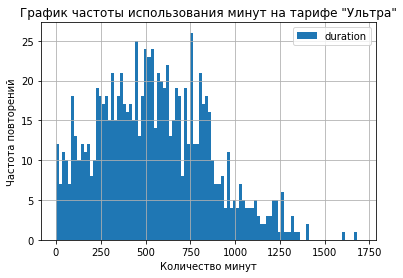

In [151]:
#ultra.duration.hist(bins=100, range=(1,1700))
ax = ultra.plot(y='duration', kind='hist', bins=100, range=(1,1700), figsize = (6, 4), grid=True, title='График частоты использования минут на тарифе "Ультра"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Количество минут')

Присутствуют единичные выбросы, пик смещен влево.

In [152]:
ultra_gb = ultra.pivot(index='user_id', columns='month', values='gb_used')

In [153]:
ultra_gb.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,9.00,22.00,37.00,55.00,66.00,83.00,90.00,106.00,114.00,122.00,133.00,138.00
mean,12.83,12.55,17.12,16.43,19.20,18.70,20.24,19.30,18.92,19.74,19.47,21.44
std,6.70,10.23,10.69,9.49,9.60,8.90,9.65,10.11,9.13,9.45,9.56,10.01
min,0.64,0.94,2.99,0.52,0.00,2.48,2.63,1.58,0.48,0.43,2.39,0.36
25%,7.96,4.28,6.05,9.75,12.71,11.27,13.71,11.56,11.88,13.73,12.17,14.50
50%,14.44,9.43,17.09,16.26,18.47,19.20,19.55,18.56,19.48,19.88,18.08,21.48
75%,18.83,19.86,27.16,22.52,26.71,24.62,26.46,27.40,26.57,25.66,26.32,27.45
max,19.22,31.86,36.45,36.24,42.80,41.26,44.12,47.22,41.19,48.58,43.26,42.90


В среднем пользователям *Ultra* достаточно около 18 Гб. Получается, почти большинству таким пользователям было бы достаточно оказаться на тарифе *Smart*.

In [155]:
np.var(ultra_gb, ddof=1)

month
2018-01-01     44.946761
2018-02-01    104.615662
2018-03-01    114.367737
2018-04-01     90.079123
2018-05-01     92.153391
2018-06-01     79.140952
2018-07-01     93.148408
2018-08-01    102.158981
2018-09-01     83.438360
2018-10-01     89.208404
2018-11-01     91.466399
2018-12-01    100.136683
dtype: float64

In [156]:
np.std(ultra_gb, ddof=1)

month
2018-01-01     6.704235
2018-02-01    10.228180
2018-03-01    10.694285
2018-04-01     9.491002
2018-05-01     9.599656
2018-06-01     8.896120
2018-07-01     9.651342
2018-08-01    10.107373
2018-09-01     9.134460
2018-10-01     9.445020
2018-11-01     9.563807
2018-12-01    10.006832
dtype: float64

Text(0.5, 0, 'Количество Гб')

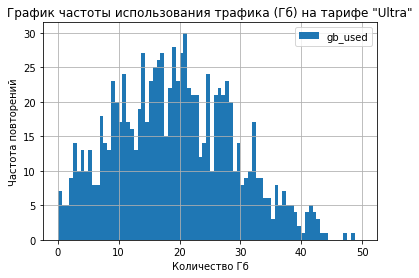

In [157]:
#ultra.gb_used.hist(bins=80, range=(0,50))
ax = ultra.plot(y='gb_used', kind='hist', bins=80, range=(0,50), figsize = (6, 4), grid=True, title='График частоты использования трафика (Гб) на тарифе "Ultra"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Количество Гб')

In [158]:
ultra_extra_gb_change = ultra[(ultra['gb_used'] - 30)>=0]
(ultra_extra_gb_change['gb_overrun'] * 150).sum()

108213.0

Дополнительная выручка от перерасхода составила 108 213 рублей.

In [159]:
ultra_revenue = ultra.pivot(index='user_id', columns='month', values='revenue')

In [160]:
ultra_revenue.describe().round(2)

month,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
count,9.0,24.00,37.00,55.00,67.00,84.00,91.00,107.00,116.00,126.00,141.00,149.00
mean,1950.0,1972.66,2003.54,1995.02,2054.48,2031.54,2107.76,2070.38,2012.63,2053.75,2073.56,2113.59
std,0.0,76.82,185.63,174.00,394.01,297.37,420.74,375.26,219.64,366.70,374.26,443.47
min,1950.0,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00
25%,1950.0,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00
50%,1950.0,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00
75%,1950.0,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00,1950.00
max,1950.0,2229.10,2918.03,2886.20,3869.66,3639.06,4068.27,4532.75,3628.98,4736.97,3938.80,3885.26


In [162]:
ultra['revenue'].sum()

2069920.8837890625

В среднем каждый пользователь этого тарифа приносит 1950 рублей - это как раз наша абонентская плата.

Text(0.5, 0, 'Расходы на связь по тарифу *Ultra* (руб.)')

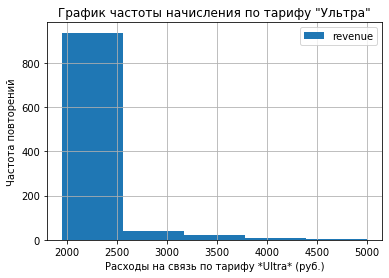

In [163]:
#ultra.revenue.hist(bins=5, range=(1950,5000))
ax = ultra.plot(y='revenue', kind='hist', bins=5, range=(1950,5000), figsize = (6, 4), grid=True, title='График частоты начисления по тарифу "Ультра"')
ax.set_ylabel('Частота повторений')
ax.set_xlabel('Расходы на связь по тарифу *Ultra* (руб.)')

In [164]:
print(smart['revenue'].sum().round(2), ultra['revenue'].sum().round(2))
smart['revenue'].sum()>ultra['revenue'].sum()

2755855.99 2069920.88


True

### Вывод

Абоненты тарифа *smart* в целом укладываются в рамки своего тарифа, в среднем это 36 сообщений, 390 минут разговора, около 15 Гб трафика. Чаще всего переплачивают именно за превышения лимита по трафику и звонкам
*Smart* принес дополнительную выручку около 580 тысяч рублей (579663 рубля), из них:
- на смс - 38784 рубля;
- на звонках - 278217 рубля;
- на трафике - 262662 рубля.
Very Smart!

Абоненты тарифа *ultra* почти всегда в рамки своего тарифа, им достаточно в среднем отправить 55 сообщений, наговорить 500 минут, и израсходовать около 18 Гб трафика. Переплата составила около 108213 рублей.

Вероятно, с появлением различных мессенджеров, пользователи постепенно все чаще начинают их использовать в противовес отправлению смс и обычным звонкам.
Пользователи *Smart* приносят больше выручки, чем пользователи тарифа *Ultra* за счет дополнительных расходов смс, трафика и минут сверх тарифа.

### Проверяем гипотезы <a class="anchor" id="chapter4"></a>

Нулевая гипотеза H₀ - гипотеза, которая проверяется на выборке. Обычно в качестве нулевой гипотезы выбирают простое осторожное утверждение, которое мы бы считали верным, если бы данных не было.

Сформируем нулевую гипотезу для каждого случая и посчитаем p-value для сравнения средних двух выборок.
Уровень значимости: $\alpha == 0.05$

#### Гипотеза 1: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается <a class="anchor" id="section_4_1"></a>

Нулевая гипотеза $H_{0}$: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.

Если p-value будет меньше выбранного уровня значимости $\alpha == 0.05$, то нулевую гипотезу отвергнем.

In [171]:
results = st.ttest_ind(ultra['revenue'], smart['revenue'], equal_var=False)
results.pvalue

1.4061101199954427e-307

In [172]:
print('p-значение: ', results.pvalue)
    
if (results.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.4061101199954427e-307
Отвергаем нулевую гипотезу


Гипотеза 1 подтверждена. Средняя выручка пользователей на разных тарифах различается, потому что удалось отвергнуть нулевую гипотезу.

#### Гипотеза 2: Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов <a class="anchor" id="section_4_2"></a>

Нулевая гипотеза $H_{0}$: Cредняя выручка пользователей из Москвы и пользователей из других регионов одинакова.

Если p-value будет меньше выбранного уровня значимости $\alpha == 0.05$, то нулевую гипотезу отвергнем.

In [174]:
moscow = df[df['city']=='Москва']

In [175]:
other_regions = df[df['city']!='Москва']

In [182]:
results = st.ttest_ind(moscow['revenue'], other_regions['revenue'], equal_var=False)
results.pvalue

0.35664522349348615

In [183]:
print('p-значение: ', results.pvalue)
    
if (results.pvalue < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.35664522349348615
Не получилось отвергнуть нулевую гипотезу


Гипотеза 2 опровергнута. Средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других регионов. Наша нулевая гипотеза подтверждена.

### Общий вывод <a class="anchor" id="chapter5"></a>

Мы изучили среднее поведение пользователей тарифа "Ультра" и "Смарт" компании "Мегалайн".
Выяснили, что пользователи тарифа "Смарт" в большинстве случаев расходуют минуты и трафик сверх лимита, по этому тарифу дополнительная выручка больше, чем на тарифе "Ультра". Пользователи тарифа "Ультра" почти все используют возможности тарифа в рамках лимита, доплачивая только за трафик.
В целом, выручка по "Ультре" значительно больше, чем выручка по "Смарту".

Одновременно с этим, мы подтвердили предложенную гипотезу о том, что средняя выручка по тарифу "Смарт" больше, чем по тарифу "Ультра". Соответственно, можем предположить, что тариф *Смарт* является перспективным для "Мегалайна".
Отметим, что вторая гипотеза о большей выручке от пользователей из столицы оказалась отвергнутой. В среднем, выручка по всем пользователям из разных городов не отличается между собой.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены и исправлены ошибки в данных
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано для каждого пользователя: количество сделанных звонков и израсходованных минут разговора по месяцам
- [x]  посчитано для каждого пользователя: количество отправленных сообщений по месяцам
- [x]  посчитано для каждого пользователя: объем израсходованного интернет-трафика по месяцам
- [x]  посчитано для каждого пользователя: помесячную выручку с каждого пользователя
- [x]  изучены следующие параметры: Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц
- [x]  посчитано среднее количество, дисперсия и стандартное отклонение
- [x]  построены гистограммы и описаны распределения
- [x]  выполнено задание: "Проверить гипотезу: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"
- [x]  выполнено задание: "Проверить гипотезу: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод